In [14]:
from pycromanager import Core, JavaObject, Studio, JavaClass
import re
import numpy as np
from cv2 import warpAffine
import cv2
from pathlib import Path
import matplotlib.pyplot as plt

np.set_printoptions(precision=3, suppress=True)

plotpath = Path().cwd().parent / "plots" / "calibration"

core = Core()
print(core)

In [2]:
# from pycromanager import 

# studio = Studio("mmcorej")

projector_api = JavaObject("org.micromanager.projector.ProjectorAPI", new_socket=True, debug=True)
# projector_api.calibrate(False)
mapping = projector_api.load_mapping(projector_api.get_projection_device())

dev = core.get_slm_device()
h = core.get_slm_height(dev)
w = core.get_slm_width(dev)

In [3]:
m = mapping.get_map().values()

In [4]:
# print(m.to_string())
pattern = r"AffineTransform\[\[([-+]?\d*\.?\d+(?:[eE][-+]?\d+)?), ([-+]?\d*\.?\d+(?:[eE][-+]?\d+)?), ([-+]?\d*\.?\d+(?:[eE][-+]?\d+)?)\], \[([-+]?\d*\.?\d+(?:[eE][-+]?\d+)?), ([-+]?\d*\.?\d+(?:[eE][-+]?\d+)?), ([-+]?\d*\.?\d+(?:[eE][-+]?\d+)?)\]\]"

# Find all matches
matches = re.findall(pattern, m.to_string())

M = np.stack(np.array(matches).astype(float)).reshape(-1, 2, 3)
at = np.median(M, axis=0)
print(f"Affine Transform from calibration: {at}")

Affine Transform from calibration: [[  -0.289    0.006  959.025]
 [  -0.012   -0.579 1540.03 ]]


In [6]:

# left = 0
# right = 2960

# imfile = Path().cwd() / "test.png"
# aa = cv2.imread(str(imfile), cv2.IMREAD_GRAYSCALE)
# # aa = 255 - aa[:h, 800:w+800]
# img = warpAffine(aa.astype(np.uint8), at, (w, h))

# fig, axes = plt.subplots(1, 3)
# axes[0].imshow(aa, cmap="gray")
# # axes[1].imshow(img, cmap="gray")

# img = img.flatten()
# core.set_slm_image(dev, img)
# core.snap_image()
# tagged_image = core.get_tagged_image()
# pixels = np.reshape(tagged_image.pix,
#                         newshape=[tagged_image.tags['Height'], tagged_image.tags['Width']])
# axes[1].imshow(pixels,cmap="gray")
# axes[2].imshow(pixels - aa, cmap="gray")
# plt.show()

# # img = (np.ones(aa.shape).flatten()).astype(np.uint8)

# rectangle = JavaObject("java.awt.Rectangle", args=[left, left, right-left, right-left])

# projector_api.transform_and_set_mask(mapping, dev, img, aa.shape[1], aa.shape[0], rectangle, 4)  

In [7]:
# np.max(aa)

In [5]:
def normalize(arr):
    return (arr - np.min(arr)) / (np.max(arr) - np.min(arr))

In [8]:
# fig = plt.figure(figsize=(10, 10))
# plt.imshow(np.abs(normalize(pixels) - normalize(aa)), "gray")
# # plt.plot(sorted((normalize(pixels) - normalize(aa)).flatten()))
# plt.show()

In [9]:
# dev = core.get_slm_device()
# # h = core.get_slm_height(dev)
# # w = core.get_slm_width(dev)
# # aa = np.meshgrid(np.arange(h), np.arange(w))[1] // 2
# # img = np.ones(aa.shape).flatten().astype(np.uint8)*100
# img = img.flatten()
# core.set_slm_image(dev, img)

In [30]:
out_img = []
vals = [50, 100, 150, 200, 250]

core.set_config("Channel", "545")
core.set_config("LightPath", "Fluor")
core.set_property("Celesta", "GREEN_Intensity", 25)

core.set_exposure(10)

core.snap_image()    
tagged_image = core.get_tagged_image()
laser_img = np.reshape(tagged_image.pix, newshape=[tagged_image.tags['Height'], tagged_image.tags['Width']])


core.set_config("LightPath", "DMD")
core.set_config("Channel", "DMD")
core.set_exposure(100)

for val in vals: 
    
    img = img = np.ones((w, h))*val
    img = img.astype(np.uint8)
    print(np.max(img))
    
    
    img = img.flatten()
    core.set_slm_image(dev, img)
    core.snap_image()
    
    tagged_image = core.get_tagged_image()
    pixels = np.reshape(tagged_image.pix,
                            newshape=[tagged_image.tags['Height'], tagged_image.tags['Width']])

    out_img.append(pixels)


50
100
150
200
250


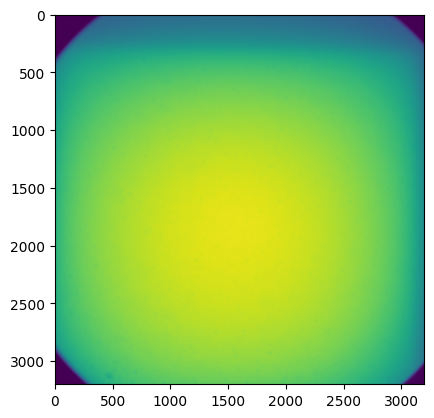

In [31]:
plt.imshow(laser_img)
plt.show()

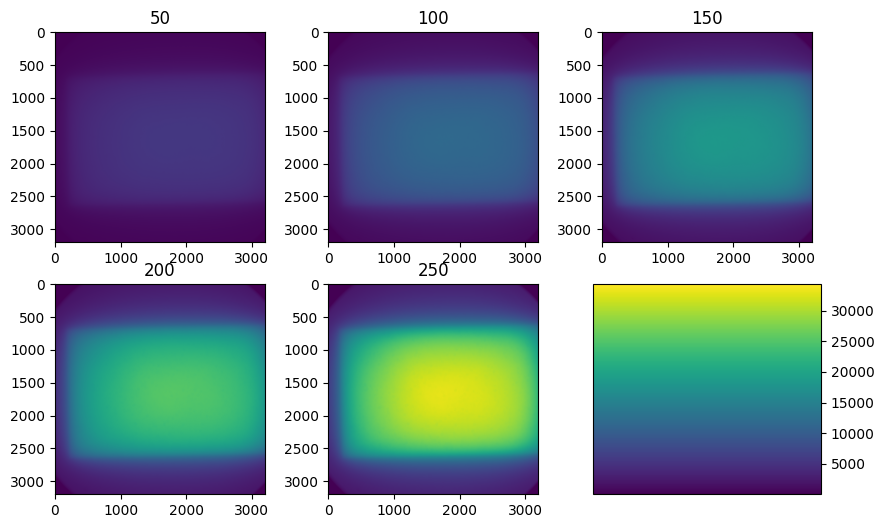

In [28]:
fig, axes = plt.subplots(2, 3, figsize=(10, 6))

for img, val, ax in zip(out_img, vals, axes.flatten()):
    g = ax.imshow(img, vmax=out_img[-1].max())
    ax.set_title(val)
plt.colorbar(g, cax=axes.flatten()[-1])
plt.savefig(plotpath / "dmdIntensities.png")
plt.show()

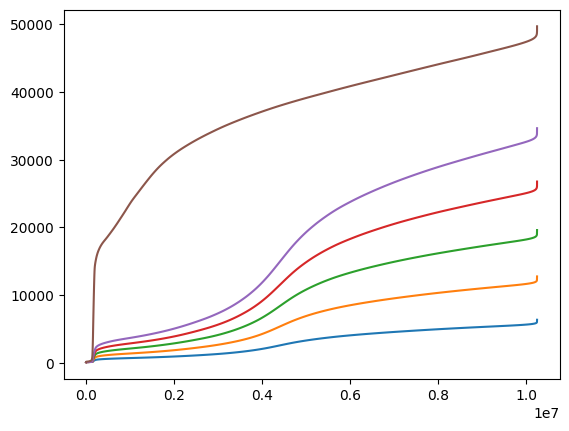

In [32]:
for img, val in zip(out_img, vals):
    plt.plot(sorted(img.flatten()), label = val)

plt.plot(sorted(laser_img.flatten()), label="laser")

plt.show()

250 50


C:\Users\Nikon\AppData\Local\Temp\ipykernel_19376\2433162365.py:14: RuntimeWarning: divide by zero encountered in divide
  xT = ((yT - y2) / m + x2)*(y2 > k) + 250*(y2 <= k)
C:\Users\Nikon\AppData\Local\Temp\ipykernel_19376\2433162365.py:14: RuntimeWarning: invalid value encountered in divide
  xT = ((yT - y2) / m + x2)*(y2 > k) + 250*(y2 <= k)
C:\Users\Nikon\AppData\Local\Temp\ipykernel_19376\2433162365.py:14: RuntimeWarning: invalid value encountered in multiply
  xT = ((yT - y2) / m + x2)*(y2 > k) + 250*(y2 <= k)


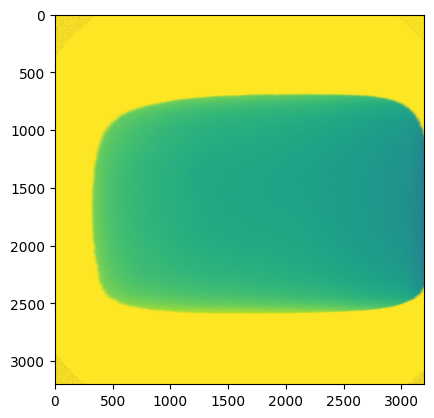

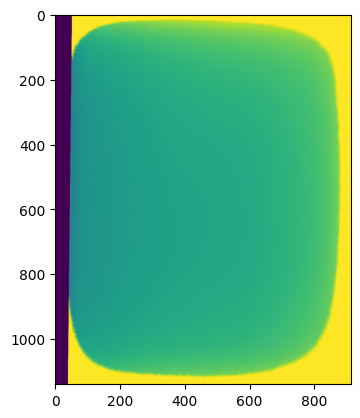

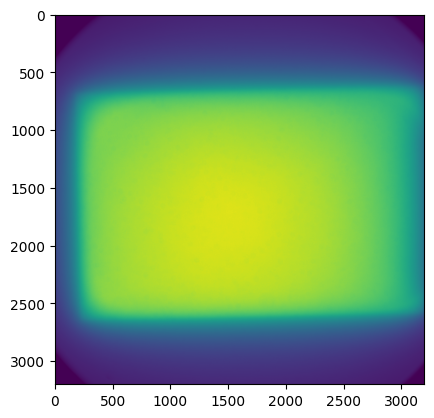

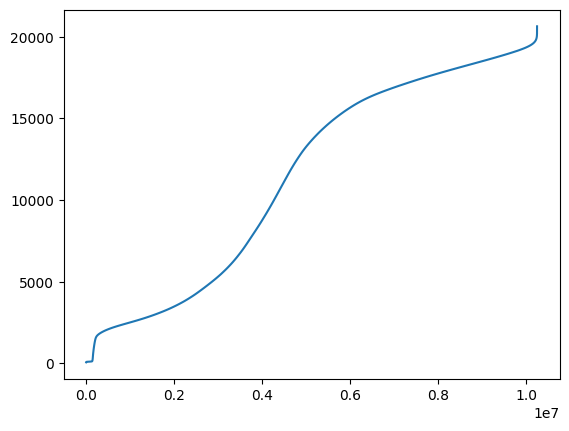

In [34]:
y1, x1 = out_img[0], vals[0]
y2, x2 = out_img[-1], vals[-1]
m = (y2 - y1) / (x2 - x1)

# print(np.max(m))
# plt.imshow(y1)
# plt.show()

print(x2, x1)

k = 20000

yT = laser_img / 2.5
xT = ((yT - y2) / m + x2)*(y2 > k) + 250*(y2 <= k)
xT = np.nan_to_num(xT)

plt.imshow(xT)
# plt.savefig(plotpath / "calibration.png")
plt.show()

cv2.imwrite(plotpath / "calibration.png", xT) 

img = warpAffine(np.round(xT).astype(np.uint8), at, (w, h))

plt.imshow(img)
plt.show()

img = img.flatten()
core.set_slm_image(dev, img)
core.snap_image()
tagged_image = core.get_tagged_image()
pixels = np.reshape(tagged_image.pix,
                        newshape=[tagged_image.tags['Height'], tagged_image.tags['Width']])

plt.imshow(pixels)
plt.savefig(plotpath / "corrected.png")
plt.show()

plt.plot(sorted(pixels.flatten()))
plt.show()

In [14]:
from scipy.signal import convolve2d
from tqdm import tqdm

def game_of_life(arr):
    f = np.ones((3, 3))
    f[1, 1] = 0
    neighbors = convolve2d(arr>0, f, "same", "fill", 0)

    return (neighbors == 3) + (neighbors == 2)*(arr > 0)


def make_display(arr, calibrator):
    out = np.zeros(calibrator.shape)

    ashape = arr.shape
    imshape = calibrator.shape

    h_shape = imshape[0] / ashape[0]
    w_shape = imshape[1] / ashape[1]
    
    for i, row in enumerate(arr):
        for j, pt in enumerate(row):
            if pt == 0:
                continue

            cv2.circle(out, (round((j + 0.5)*h_shape), round((i+0.5)*w_shape)),30, 1, -1)

    return out * calibrator

def infer_state(img, ashape, thresh=1600):
    imshape = img.shape

    h_shape = imshape[0] / ashape[0]
    w_shape = imshape[1] / ashape[1]

    arr = np.zeros(ashape)
    vals = np.zeros(ashape)

    for i in range(ashape[0]):
        for j in range(ashape[1]):
            bbox = [
                round(i*h_shape),
                min(round((i+1)*h_shape), imshape[0]),
                round(j*w_shape),
                min(round((j+1)*w_shape), imshape[1]),
            ]
            
            val = np.max(img[bbox[0]:bbox[1], bbox[2]:bbox[3]])
            vals[i, j] = val
            # print(val)
            
            if val > thresh:
                arr[i, j] = 1

    # plt.plot(sorted(vals.flatten()))
    # plt.show()
    
    return arr > 0

def apply_img(img):
    img = warpAffine(np.round(img).astype(np.uint8), at, (w, h))

    img = img.flatten()
    core.set_slm_image(dev, img)

def snap_and_save():
    core.snap_image()
    tagged_image = core.get_tagged_image()
    pixels = np.reshape(tagged_image.pix,
                            newshape=[tagged_image.tags['Height'], tagged_image.tags['Width']])

    return pixels

arr = np.random.choice([0, 1], (30, 30), True, [0.75, 0.25])

save_path = Path().cwd() / "gol_snaps"
save_path.mkdir(exist_ok=True)

for n in tqdm(range(100)):
    img = make_display(arr, xT)
    # plt.imshow(img)
    # plt.show()

    img = warpAffine(np.round(img).astype(np.uint8), at, (w, h))

    # plt.imshow(img)
    # plt.show()
    # print(np.max(img))

    img = img.flatten()
    core.set_slm_image(dev, img)
    core.snap_image()
    tagged_image = core.get_tagged_image()
    pixels = np.reshape(tagged_image.pix,
                            newshape=[tagged_image.tags['Height'], tagged_image.tags['Width']])

    # plt.imshow(pixels)
    # plt.show()

    cv2.imwrite(str(save_path / f"{n:02d}.png"), (normalize(pixels)*255).astype(np.uint8))

    state = infer_state(pixels, arr.shape)

    # plt.imshow(state)
    # plt.show()

    

    arr = game_of_life(state)



100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:48<00:00,  2.06it/s]
